In [1]:
import logging
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin

logger = logging.getLogger(__name__)
setup_stream_logger(logger, level=logging.DEBUG)

In [2]:
from marss2l import loaders
import os
fs = get_remote_filesystem()

os.makedirs("figures", exist_ok=True)

Using account key


In [3]:
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv"
dataframe_data_traintest = loaders.read_csv(csv_path, 
                                            add_columns_for_analysis=True, 
                                            add_case_study=True,
                                            split="all",
                                            fs=None)
dataframe_data_traintest.shape

Using account key


(93581, 58)

In [4]:
dataframe_data_traintest.columns

Index(['id_loc_image', 's2path', 'plumepath', 'cloudmaskpath', 'ch4path',
       'location_name_short', 'wind_u', 'wind_v', 'wind_speed', 'vza', 'sza',
       'percentage_clear', 'tile', 'isplume', 'ch4_fluxrate',
       'ch4_fluxrate_std', 'satellite', 'tile_date', 'notified', 'id_location',
       'last_update', 'location_name', 'country', 'lon', 'lat', 'offshore',
       'sector', 'monitoring', 'observability', 'background_image_tile',
       'footprint', 'plume', 'crs', 'transform_a', 'transform_b',
       'transform_c', 'transform_d', 'transform_e', 'transform_f', 'width',
       'height', 'window_row_off', 'window_col_off', 'window_height',
       'window_width', 'split_name', 'percent_overlap', 'year', 'year_month',
       'year_month_day', 'isplumeneg', 'date', 'satellite_constellation',
       'year_quarter', 'ch4_fluxrate_th', 'interval_ch4_fluxrate',
       'interval_ch4_fluxrate_str', 'case_study'],
      dtype='object')

In [5]:
dataframe_test = dataframe_data_traintest[dataframe_data_traintest.split_name=="test_2023"].copy()
dataframe_test.shape

(43529, 58)

In [6]:
ids_test = set(dataframe_test.id_loc_image)
len(ids_test)

43529

In [8]:
import pandas as pd
import uuid

stats_path = "az://public/MARS-S2L/dataset_20250609/stats_dataset.csv"
with fs.open(stats_path) as fh:
    dataframe_stats_original = pd.read_csv(fh)
dataframe_stats_original["id_loc_image"] = dataframe_stats_original["id_loc_image"].apply(uuid.UUID)
dataframe_stats_original["isplume"] = dataframe_stats_original.isplume.astype(bool)
dataframe_stats_original.shape

(91594, 114)

In [9]:
# Fill noplume stats with normal stats
from tqdm import tqdm
for cnoplume in tqdm(dataframe_stats_original.columns):
    if "_noplume" in cnoplume:
        cnormal = cnoplume.replace("_noplume","")
        dataframe_stats_original[cnoplume] = dataframe_stats_original.apply(lambda row: getattr(row,cnoplume) if row.isplume else getattr(row,cnormal),axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [01:51<00:00,  1.02it/s]


In [10]:
dataframe_stats = pd.merge(dataframe_stats_original, 
                           dataframe_data_traintest[["id_loc_image","offshore",'interval_ch4_fluxrate',"ch4_fluxrate", "ch4_fluxrate_std", 
                                                     'interval_ch4_fluxrate_str','year', 'year_month',"split_name", "country", "case_study",
                                                    'satellite_constellation']],
                          on="id_loc_image")
dataframe_stats["offshorestr"] = dataframe_stats["offshore"].apply(lambda x: "YES" if x else "NO")
dataframe_stats["isplumestr"] = dataframe_stats.isplume.apply(lambda x: "YES" if x >.1 else "NO")

In [11]:
# Sanity check: isplume only has npixelsplume > 0
dataframe_stats[dataframe_stats.isplume & (dataframe_stats.npixelsplume == 0)]

,location_name,tile,id_loc_image,isplume,wind_u,wind_v,npixelsplume,npixels,ch4_mean,ch4_std,...,ch4_fluxrate_std,interval_ch4_fluxrate_str,year,year_month,split_name,country,case_study,satellite_constellation,offshorestr,isplumestr


In [12]:
dataframe_stats_test = dataframe_stats[dataframe_stats.id_loc_image.isin(ids_test)].copy()
dataframe_stats_test.shape
dataframe_stats_test_isplume = dataframe_stats_test[dataframe_stats_test.isplume.astype(bool)].copy()
dataframe_stats_test_isplume.shape

(1813, 127)

In [13]:
dataframe_stats_test

,location_name,tile,id_loc_image,isplume,wind_u,wind_v,npixelsplume,npixels,ch4_mean,ch4_std,...,ch4_fluxrate_std,interval_ch4_fluxrate_str,year,year_month,split_name,country,case_study,satellite_constellation,offshorestr,isplumestr
0,011-4K-001_1,LC09_L1TP_185040_20241230_20241230_02_T1,6c766e53-1c19-450a-93d8-4a136721b930,False,0.410492,-1.204330,0.0,40000,27.438074,41.803368,...,0.0,"[0, 0]",2024,2024-12-01,test_2023,Libya,Libya,Landsat,NO,NO
1,011-4K-001_1,S2B_MSIL1C_20241226T093319_N0511_R136_T33RYN_2...,b2fdc3f5-4476-4902-a4d1-58523e54dada,False,9.142639,-2.482208,0.0,40000,81.478889,120.731422,...,0.0,"[0, 0]",2024,2024-12-01,test_2023,Libya,Libya,Sentinel-2,NO,NO
2,011-4K-001_1,S2A_MSIL1C_20241221T093421_N0511_R136_T33RYN_2...,7b31ece7-ad31-4ff4-85cd-b156babad647,False,1.702469,-2.103516,0.0,40000,100.648140,233.517685,...,0.0,"[0, 0]",2024,2024-12-01,test_2023,Libya,Libya,Sentinel-2,NO,NO
3,011-4K-001_1,LC09_L1TP_185040_20240925_20240925_02_T1,1f01fdd9-0240-4999-a389-3a4b1e0a1186,False,-0.854843,-2.715822,0.0,40000,32.093170,58.157139,...,0.0,"[0, 0]",2024,2024-09-01,test_2023,Libya,Libya,Landsat,NO,NO
4,011-4K-001_1,LC09_L1TP_185040_20240909_20240909_02_T1,8fab1041-ca3b-454c-8a1d-5870723814e6,False,-1.500580,2.065903,0.0,40000,57.665756,93.108635,...,0.0,"[0, 0]",2024,2024-09-01,test_2023,Libya,Libya,Landsat,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91578,y,LC09_L1TP_031038_20240122_20240122_02_T1,3085fdec-0f36-4f31-89af-77b5d3861ca3,False,1.213076,0.177032,0.0,40000,85.329948,143.172562,...,0.0,"[0, 0]",2024,2024-01-01,test_2023,United States of America,United States of America,Landsat,NO,NO
91579,y,S2A_MSIL1C_20240110T173711_N0510_R055_T13SFR_2...,d59dc36c-5e35-4eee-a57b-cfaa89eec880,False,3.376892,0.742538,0.0,40000,149.722870,1416.915405,...,0.0,"[0, 0]",2024,2024-01-01,test_2023,United States of America,United States of America,Sentinel-2,NO,NO
91580,y,LC09_L1TP_031038_20240106_20240106_02_T1,b7673bc3-581d-47cc-9c60-294642a40520,False,4.018646,-1.704391,0.0,40000,56.905289,79.580933,...,0.0,"[0, 0]",2024,2024-01-01,test_2023,United States of America,United States of America,Landsat,NO,NO
91581,y,S2B_MSIL1C_20240105T173729_N0510_R055_T13SFR_2...,65afddf0-51bd-4da8-994c-35b687c47bbc,False,5.205490,-0.843931,0.0,40000,131.071274,250.933426,...,0.0,"[0, 0]",2024,2024-01-01,test_2023,United States of America,United States of America,Sentinel-2,NO,NO


## Stats by case study

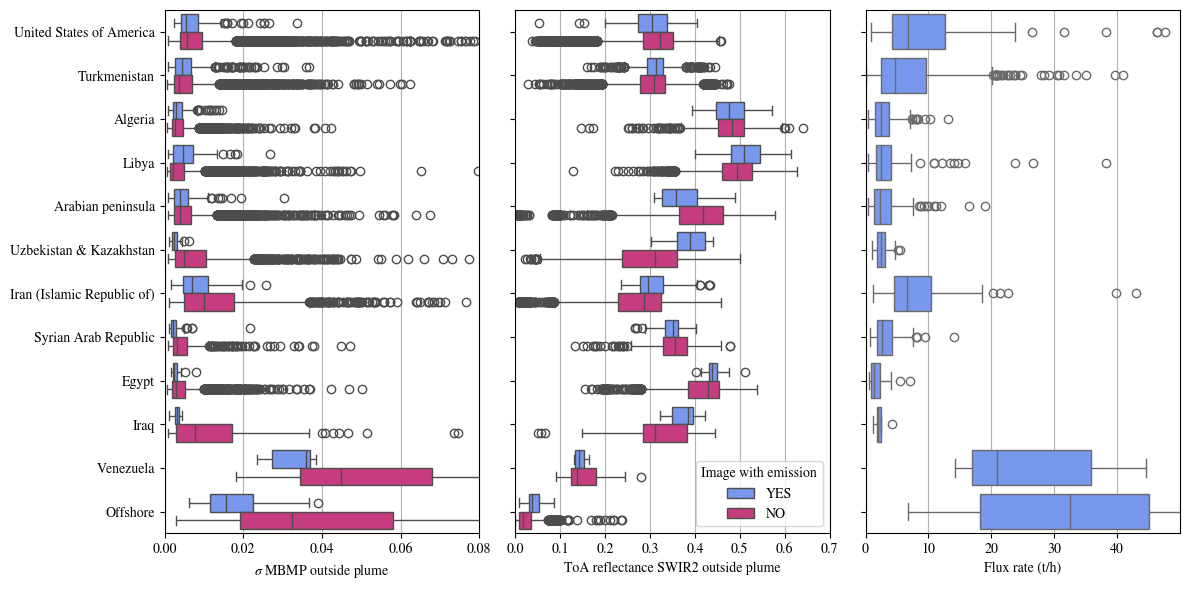

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from marss2l.plot import C0, C1, C2

fig, ax = plt.subplots(1,3, figsize=(12,6),
                       sharey=True,tight_layout=True)

case_studies_plot = [c for c in loaders.ORDER_CASE_STUDIES if c != "Rest"]

sns.boxplot(data=dataframe_stats_test, 
            x="MBMP_std_noplume", hue="isplumestr", y="case_study", ax=ax[0],legend=False,
            palette=[C0, C2], hue_order= ["YES", "NO"],
            order=case_studies_plot)
# ax[0].set_xlim(0,0.027)
ax[0].set_xlim(0,0.08)

sns.boxplot(data=dataframe_stats_test, 
            x="B12_mean_noplume", hue="isplumestr", y="case_study", ax=ax[1],
            palette=[C0, C2], hue_order= ["YES", "NO"],
            order=case_studies_plot)
sns.move_legend(ax[1], "lower right" ,title="Image with emission")
ax[1].set_xlabel(r"ToA reflectance SWIR2 outside plume")
ax[0].set_xlabel(r"$\sigma$ MBMP outside plume")
ax[0].set_ylabel("")
ax[1].set_xlim(0,0.7)

sns.boxplot(data=dataframe_stats_test, 
            x="Q",y="case_study", ax=ax[2],
            color=C0,
            order=case_studies_plot)

for axs in ax:
    axs.xaxis.grid(True)

ax[2].set_xticks(range(0, 50_000, 10_000), [f"{d/1000:.0f}" for d in range(0, 50_000, 10_000)])
ax[2].set_xlabel("Flux rate (t/h)")
ax[2].set_xlim(0,50_000)
fig.savefig("figures/stats_toa_mbmp.pdf")

## Plumes detected with low ToA reflectance

In [15]:
weird_onshore_plumes = dataframe_stats_test_isplume[~dataframe_stats_test_isplume.offshore & \
                                                          (dataframe_stats_test_isplume.B12_mean_noplume < 0.2)].copy()
weird_onshore_plumes[["location_name", "tile", "id_loc_image", "Q", "B12_mean_noplume"]].sort_values("Q", ascending=False)

,location_name,tile,id_loc_image,Q,B12_mean_noplume
26076,CHN_qq9g4wd9e,S2B_MSIL1C_20241023T030709_N0511_R075_T50SMJ_2...,b0df8c90-2066-425a-9f39-15c4cf27b69f,305363.966760,0.154821
86263,USA_hkth1ywhh,LC09_L1TP_027036_20241109_20241109_02_T1,9780ab2e-7170-4839-b13e-0d2545fd8a02,129194.493294,0.142115
86261,USA_hkth1ywhh,S2B_MSIL1C_20241111T170439_N0511_R069_T14SQC_2...,f5f18f8b-c0ac-4bc2-885a-e9b83edf9bf4,124929.598045,0.153612
26056,CHN_qq82d97ox,S2A_MSIL1C_20241120T032031_N0511_R118_T49SFV_2...,06491efa-726a-4b2f-a771-7ab69e3241b1,120883.138612,0.142582
86775,USA_w7e8ngghj,S2B_MSIL1C_20241023T163249_N0511_R083_T16RBV_2...,9123854a-64f6-4791-9255-63ad109e0896,47586.010859,0.052162
88361,VEN_whwgthbp0,S2B_MSIL1C_20241106T144729_N0511_R139_T20PMR_2...,fc3ac2a0-816a-437d-99c6-f7210dd6c3bb,44620.753583,0.131862
88363,VEN_whwgthbp0,LC08_L1TP_002053_20241017_20241022_02_T1,9bf6fa08-0a0e-4f56-bec4-879eb69382cf,39890.578127,0.138915
88367,VEN_whwgthbp0,S2B_MSIL1C_20240220T144729_N0510_R139_T20PMR_2...,d916b2e9-aa22-46c3-bfd3-07eaad328946,23661.834741,0.165026
88333,VEN_0003,S2A_MSIL1C_20240428T145731_N0510_R039_T20PKS_2...,02e43c1e-4e58-485f-a3e1-34e9cf9aad68,18067.894399,0.155305
75827,T_25,LC08_L1TP_163034_20240416_20240416_02_RT,de391981-c893-4381-8b5a-e687f2ee8c8e,17793.194280,0.194405


## Stats size of the plume

In [16]:
dataframe_stats_isplume = dataframe_stats[dataframe_stats.isplume].copy()
 # & (dataframe_stats.npixelsplume == 0)]
dataframe_stats_isplume.shape

(5749, 127)

Text(0.5, 0, '# pixels plume (10m resolution)')

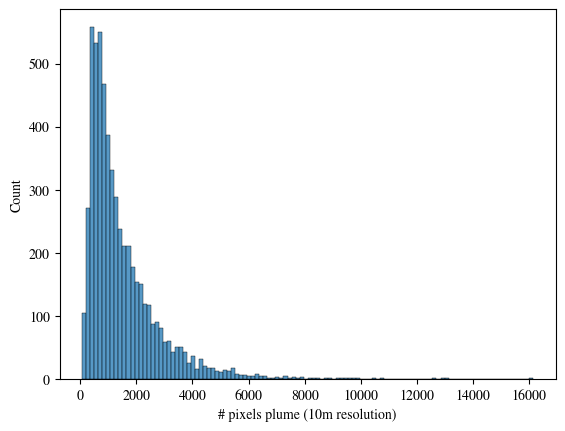

In [17]:
ax = sns.histplot(data=dataframe_stats_isplume, x="npixelsplume",
                  common_norm=False)
ax.set_xlabel("# pixels plume (10m resolution)")

Text(0.5, 0, '# pixels plume (10m resolution)')

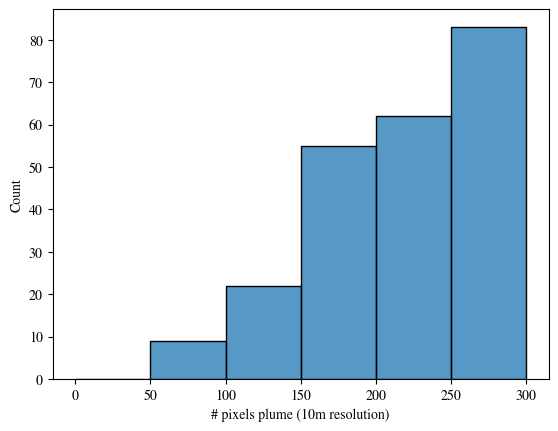

In [18]:
import numpy as np
ax = sns.histplot(data=dataframe_stats_isplume[dataframe_stats_isplume.npixelsplume < 300], 
             x="npixelsplume",
             bins = np.arange(0,301,50),
             # hue_order=[False, True],
             common_norm=False)
ax.set_xlabel("# pixels plume (10m resolution)")